(foundations:symbolic_interpreter)=
# A Symbolic Interpreter and Correctness of Symbolic Transitions

Executing a program with the concrete minipy interpreter updates the passed environment, and potentially raises an exception. Symbolic execution, in contrast, takes into account all feasible paths through a program. We distinguish between *online* and *offline* SE (see, e.g., {cite}`baldoni.coppa.ea-18`). Online SE executes multiple symbolic paths simultaneously: For example, executing an `if` statement leads to two paths which are both explored. Offline SE reasons about one single path at a time. *Concolic execution*, where SE is guided by a single *concrete* input, is an example of the latter class. In this section, we regard *online* SE. Symbolically executing a program in an online symbolic interpreter results in multiple output environments. Also, such an interpreter cannot simply raise an exception, as this would result in a premature termination of the analysis, skipping other feasible program paths. The consequences for our static, online symbolic interpreter are:

* Instead of updating the initial symbolic environment, the interpreter produces potentially multiple new environments. Our interpreter even outputs all *intermediate* states, such that the output is a *Symbolic Execution Tree* (SET).
* Thrown exceptions are stored in the symbolic environment instead of being raise. Thus, we need another field in our `SymbolicEnvironment` class.

We implement these changes subsequently. Afterward, we show how to implement a static, online symbolic interpreter for minipy, and introduce the correctness properties *exhaustiveness* and *precision* for symbolic execution. Finally, we show how these definitions can be used to *automatically test* the symbolic interpreter. Using this methodology, we discovered two bugs of precious versions of our implementation, one of which is related to a subtle difference in the division semantics in z3 and Python.

## Symbolic Execution Trees

We first update the implementation of `SymbolicEnvironment` to include abrupt completion information:

In [1]:
import utils
from minipy import *
from semantics import *

In [2]:
class SymbolicEnvironment(SymbolicEnvironment):
    def __init__(self,
                 store: Optional[SymbolicStore] = None,
                 path_constraints: Optional[Set[z3.BoolRef]] = None,
                 abrupt_completion: Optional[Exception] = None,
                 functions: Optional[Dict[str, Tuple[Tuple[Variable], Type, Callable]]] = None):
        super().__init__(store, path_constraints, functions)
        self.abrupt_completion = abrupt_completion

    def copy(self):
        return SymbolicEnvironment(self.store, self.path_constraints, self.abrupt_completion, self.functions)

    def set(self, variable: Variable, value: SymbolicValueType) -> 'SymbolicEnvironment':
        return SymbolicEnvironment(self.store.set(variable, value), self.path_constraints,
                                   self.abrupt_completion, self.functions)

    def set_abrupt_completion(self, exc: Optional[Exception]) -> 'SymbolicEnvironment':
        return SymbolicEnvironment(self.store, self.path_constraints, exc, self.functions)

    def add_constraint(self, constraint: z3.BoolRef) -> 'SymbolicEnvironment':
        if z3.is_false(z3.simplify(constraint)):
            new_constraints = {z3.BoolVal(False)}
        elif z3.is_true(z3.simplify(constraint)):
            return self
        else:
            new_constraint = self.store.apply_to(constraint)
            old_constraints = {constraint for constraint in self.path_constraints
                               if not implies(new_constraint, constraint)}
            new_constraints = old_constraints | {new_constraint}

        return SymbolicEnvironment(self.store, new_constraints, self.abrupt_completion, self.functions)


    def add_function(self, name: str, params: Tuple[Variable], type: Type, impl: Callable) -> 'SymbolicEnvironment':
        new_functions = copy.deepcopy(self.functions)
        new_functions[name] = (params, type, impl)
        return SymbolicEnvironment(self.store, self.path_constraints, self.abrupt_completion, new_functions)

    def __str__(self):
        return ("(" +
                ("{}" if not self.path_constraints else str(self.path_constraints)) + ", " +
                str(self.store) +
                ("" if self.abrupt_completion is None else repr(self.abrupt_completion)) +
                ")")

    def to_html(self):
        prev_html = z3.in_html_mode()
        z3.set_html_mode(True)

        path_constraint_string = "{"
        if self.path_constraints:
            path_constraint_string += ", ".join(map(z3_html_escape, map(z3.obj_to_string, self.path_constraints)))
        path_constraint_string += "}"

        path_constraint_string = path_constraint_string.replace("\n", "<BR/>").replace(" ", "&nbsp;")

        result = f"({path_constraint_string}, "
        if self.abrupt_completion:
            result += f"{repr(self.abrupt_completion)}, "
        result += f"{self.store.to_html()})"

        z3.set_html_mode(prev_html)
        return result

    def __repr__(self):
        result = f"SymbolicEnvironment({repr(self.store)}, " \
                 f"{repr(self.path_constraints)}, " \
                 f"{repr(self.abrupt_completion)}, "
        result += repr({f_name: f"fun {f_name}{params} -> "
                                f"{type}" for f_name, (params, type, _) in self.functions.items()})
        return f"{result})"

    def __eq__(self, other):
        return isinstance(other, SymbolicEnvironment) and self.store == other.store and \
               self.path_constraints == other.path_constraints and \
               self.functions == other.functions and \
               (self.abrupt_completion == other.abrupt_completion is None or
                ExceptionWrapper(self.abrupt_completion) == ExceptionWrapper(other.abrupt_completion))


Next, we define a class for nodes in an SET. An SET node comprises a symbolic environment and a string representation of the next instruction to execute. We also define a `to_html` method to produce pretty output.

In [3]:
class SETNode:
    def __init__(self, environment: SymbolicEnvironment, pc: Optional[Union[ParseTree, str]] = None):
        self.environment = environment
        self.pc = pc

    @property
    def pc(self):
        return self.__pc

    @pc.setter
    def pc(self, pc: Optional[Union[ParseTree, str]]):
        if pc is None:
            self.__pc = ""
        else:
            assert isinstance(pc, str)
            self.__pc = pc.split("\n")[0].strip()

    def to_html(self):
        prev_html = z3.in_html_mode()
        z3.set_html_mode(True)

        result = f'<TABLE BORDER="0"><TR>'
        if "<BR/>" in self.environment.to_html():
            result += f'<TD BALIGN="LEFT" ALIGN="LEFT">{self.environment.to_html()}</TD>'
        else:
            result += f'<TD>{self.environment.to_html()}</TD>'
        result += "</TR>"

        if self.pc:
            result += '<TR><TD ALIGN="CENTER"><FONT FACE="Courier">' + z3_html_escape(self.pc) + "</FONT></TD></TR>"
        result += "</TABLE>"

        z3.set_html_mode(prev_html)
        return result

    def __repr__(self):
        return f"SETNode({repr(self.environment)}, {repr(self.pc)})"

    def __eq__(self, other):
        return type(other) is type(self) and self.environment == other.environment and self.pc == other.pc

Symbolic execution trees themselves are defined just like derivation trees, only with `SETNode`s instead of strings as nodes.

In [4]:
SET = Tuple[SETNode, List['SET']]

The following function produces graphical representations (using GraphViz) of SETs. Leaves are highlighted using the following color scheme: Red leaves represent raised exceptions, green leaves represent nodes with unsatisfiable path conditions, and blue leaves all other nodes containing "normal" computation results.

In [5]:
from graphviz import Digraph

In [6]:
def display_set(symbolic_execution_tree: SET) -> Digraph:
    def traverse_tree(dot: Digraph, tree: SET, node_id=0):
        node, children = tree
        
        attrs = {}
        if node.environment.unsatisfiable():
            attrs = {"fillcolor": "lightgreen", "style": "filled"}
        elif (node.environment.abrupt_completion is not None and
              not isinstance(node.environment.abrupt_completion, AbruptCompletionNoException)):
            attrs = {"fillcolor": "lightpink1", "style": "filled"}
        elif not children:
            attrs = {"fillcolor": "paleturquoise2", "style": "filled"}

        dot.node(repr(node_id), "<" + node.to_html() + ">", _attributes=attrs)

        if children:
            for child in children:
                nonlocal counter
                counter += 1
                child_id = counter
                dot.edge(repr(node_id), repr(child_id))
                traverse_tree(dot, child, child_id)

    counter = 0
    dot = Digraph(comment="Symbolic Execution Tree")
    dot.attr('node', shape='box')
    traverse_tree(dot, symbolic_execution_tree)
    return dot

Recall our small example from the previous section:

In [7]:
x = 0
y = 0

In [8]:
x = 2 * y
if x < 0:
    x = -x

The final SET resulting from symbolically executing this program will contain two leaves, one branch each for the case where the condition of the `if` statements hold or does not hold, respectively. Apart from the root, it also contains two inner nodes corresponding to the first assignment and the `if` statement. In the absence of an implemented symbolic interpreter, we manually construct this SET:

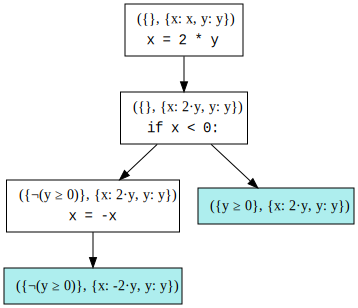

In [9]:
x = Variable("x", INT_TYPE)
y = Variable("y", INT_TYPE)

env_0 = SymbolicEnvironment(SymbolicStore({x: x.to_z3(), y: y.to_z3()}))
env_1 = env_0.set(x, z3.IntVal(2) * y.to_z3())
env_2 = env_1.add_constraint(x.to_z3() < z3.IntVal(0))
env_2_1 = env_2.set(x, z3.IntVal(-1) * x.to_z3())
env_3 = env_1.add_constraint(z3.Not(x.to_z3() < z3.IntVal(0)))

root = SETNode(env_0, "x = 2 * y")
if_node = SETNode(env_1, "if x < 0:")
inversion_node = SETNode(env_2, "x = -x")
leave_1 = SETNode(env_2_1)
leave_2 = SETNode(env_3)

tree = (root, [
    (if_node, [
        (inversion_node, [(leave_1, [])]),
        (leave_2, [])])])

display_set(tree)

## Evaluating Expressions

Also the symbolic evaluation of expressions can have multiple results. Consider the expression `y // x`: Depending on whether `x` is zero or non-zero, evaluating this expression results in a value or a `ZeroDivisionError`. Thus, our result type for expression evaluation is a collection of pairs of either a value or an exception, together with a boolean constraint signaling under which condition the respective result is returned.

In [10]:
EvalExprResult = List[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]]

We define a helper function `handle_binary_operation` computing all conditioned results for a binary operation (e.g., division or conjunction) applied on two evaluation results.

In [11]:
def handle_binary_operation(left: EvalExprResult, right: EvalExprResult, op: str) -> EvalExprResult:
    result = []

    for left_result in left:
        left_val, left_constr = left_result

        if isinstance(left_val, Exception):
            result.append(left_result)
            continue

        if op == "and":
            result.append((z3.BoolVal(False), z3.And(left_constr, z3.Not(left_val))))
        if op == "or":
            result.append((z3.BoolVal(True), z3.And(left_constr, left_val)))

        for right_result in right:
            right_val, right_constr = right_result
            constraint_conjunction = z3.And(left_constr, right_constr)
            constraint_conjunction = z3_and(z3.simplify(constraint_conjunction))

            if z3.is_false(constraint_conjunction):
                continue

            if isinstance(right_val, Exception):
                # Short-circuit evaluation:
                if op == "or":
                    constraint_conjunction = z3.And(constraint_conjunction, z3.Not(left_val))
                elif op == "and":
                    constraint_conjunction = z3.And(constraint_conjunction, left_val)

                constraint_conjunction = z3_and(z3.simplify(constraint_conjunction))
                if not z3.is_false(constraint_conjunction):
                    result.append((right_val, constraint_conjunction))

                continue

            left_val: Union[z3.ArithRef, z3.BoolRef]
            right_val: Union[z3.ArithRef, z3.BoolRef]

            operator_map = {
                "+": lambda a, b: z3.Concat(a, b) if isinstance(a, z3.SeqRef) else a + b,
                "-": operator.sub,
                "*": operator.mul,
                "==": operator.eq,
                "!=": lambda a, b: z3.Not(a == b),
                "<": operator.lt,
                "<=": operator.le,
                ">": operator.gt,
                ">=": operator.ge,
                "and": lambda a, b: z3.And(a, b),
                "or": lambda a, b: z3.Or(a, b)
            }

            if op in operator_map:
                result.append((operator_map[op](left_val, right_val), constraint_conjunction))
                continue

            right_zero = right_val == z3.IntVal(0)
            right_nonzero = z3.Not(right_zero)

            if op == "//":
                result.append((z3.ToInt(z3.ToReal(left_val) / z3.ToReal(right_val)),
                               z3.And(constraint_conjunction, right_nonzero)))
                result.append((ZeroDivisionError("division by zero"),
                               z3.And(constraint_conjunction, right_zero)))
                continue

            if op == "%":
                result.append((left_val % right_val, z3.And(constraint_conjunction, right_nonzero)))
                result.append((ZeroDivisionError("division by zero"),
                               z3.And(constraint_conjunction, right_zero)))
                continue

            assert False

    return [
        (val if isinstance(val, Exception) 
         else z3.simplify(val), z3.simplify(constraint)) 
        for val, constraint in result
    ]

In [12]:
x = Variable("x", INT_TYPE)
y = Variable("y", INT_TYPE)

result = handle_binary_operation(
    [(x.to_z3(), z3.BoolVal(True))],
    [(y.to_z3(), z3.BoolVal(True))],
    "//")

display_html(str(result))

The term produced for the division, `ToInt(ToReal(x)/ToReal(y))`, might come unexpected: Why not simply `x / y`? The reason is the semantics of Python's Integer division `//`, which is a *floor division* [^floor-division]. Essentially, Python rounds towards 0 for positive, and away from 0 for negative numbers. That is, `1 // -2` evaluates to -1, while `z3.IntVal(1) / z3.IntVal(-2)` evaluates to *0*. Since the `z3.ToInt` function rounds away from zero for negative numbers, the implementation above correctly models Python's (and minipy's) floor division semantics.

Based on this function, the implementation of expression evaluation can be handled uniformly in many cases. For example, consider the evaluation of sums and terms below:

```python
class SymbolicInterpreter:
    # ...
    
    def evaluate_sum(self, expr: Sum, environment: SymbolicEnvironment) -> EvalExprResult:
        left = self.evaluate(expr.left, environment)
        right = self.evaluate(expr.right, environment)
        return handle_binary_operation(left, right, expr.op)

    def evaluate_term(self, expr: Term, environment: SymbolicEnvironment) -> EvalExprResult:
        left = self.evaluate(expr.left, environment)
        right = self.evaluate(expr.right, environment)
        return handle_binary_operation(left, right, expr.op)
    
    # ...
```

When evaluating tuple expressions, we sequentially evaluate all tuple elements and add an exception result if one of these evaluations raises an exception. We create a z3 sequence expression for the case where all tuple elements evaluate to a value. Consider the tuple `(x // y, x // (y + 1))`. Its symbolic evaluation has three results:

1. y is 0, then the tuple evaluates to a `ZeroDivisionError`.
2. y is -1, then the tuple evaluates to a `ZeroDivisionError`.
3. y does not equal either 0 or -1, then the tuple evaluates to a sequence expression containing the symbolic values corresponding to the division.

For considering all these options, we build the product of the individual evaluation results for the tuple elements. This yields a list of tuples, where each tuple has the length of the evaluated tuple and corresponds to one evaluation result. For example:

In [13]:
import itertools

In [14]:
result_1 = handle_binary_operation(
    [(x.to_z3(), z3.BoolVal(True))],
    [(y.to_z3(), z3.BoolVal(True))],
    "//")

result_2 = handle_binary_operation(
    [(x.to_z3(), z3.BoolVal(True))],
    [(y.to_z3() + z3.IntVal(1), z3.BoolVal(True))],
    "//")

results: List[EvalExprResult] = [result_1, result_2]
list(itertools.product(*results))

[((ToInt(ToReal(x)/ToReal(y)), Not(0 == y)),
  (ToInt(ToReal(x)/(1 + ToReal(y))), Not(-1 == y))),
 ((ToInt(ToReal(x)/ToReal(y)), Not(0 == y)),
  (ZeroDivisionError('division by zero'), -1 == y)),
 ((ZeroDivisionError('division by zero'), 0 == y),
  (ToInt(ToReal(x)/(1 + ToReal(y))), Not(-1 == y))),
 ((ZeroDivisionError('division by zero'), 0 == y),
  (ZeroDivisionError('division by zero'), -1 == y))]

We loop over the elements of the tuples in the list, and stop at the first exception (if any), which will be the evaluation result. Along the way, we collect the path constraints of the seen evaluation results for the tuple elements. Note that the list above contains four, and not three elements. When considering those, the third and fourth evaluation alternatives collapse to a single one, since we stop after processing the evaluation result for the first tuple element, which is an exception (the fourth element is anyway infeasible, since `y` cannot attain the values 0 and -1 at the same time).

To avoid creating the same result for equivalent evaluations (e.g., if the same exception is raised under the same condition when evaluating different tuple elements), we first collect evaluation results in a set. We wrap exceptions inside a wrapper object computing sensible hashes as Python exceptions generally do not supply a suitable hashing implementation.

```python
class SymbolicInterpreter:
    # ...
    
    def evaluate_tuple(self, expr: TupleNode, environment: SymbolicEnvironment) -> EvalExprResult:
        sub_results: List[EvalExprResult] = [self.evaluate(elem, environment) 
                                             for elem in expr.elems]
        result: OrderedSet[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]] = OrderedSet([])

        combinations: List[Tuple[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef], ...]] = \
            list(itertools.product(*sub_results))

        combination: Tuple[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef], ...]
        for combination in combinations:
            values: List[SymbolicValueType] = []
            path_constraint: z3.BoolRef = z3.BoolVal(True)
            sub_result: Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]
            for sub_value, sub_constraint in combination:
                path_constraint = z3.simplify(z3.And(path_constraint, sub_constraint))
                if isinstance(sub_value, Exception):
                    result.add(wrap_exceptions((sub_value, path_constraint)))
                    break

                values.append(sub_value)

            if len(values) != len(combination):
                continue

            if len(values) == 1:
                value = values[0]
                result.add((value if isinstance(value.sort(), z3.SeqSortRef) 
                            else z3.Unit(value), path_constraint))
            elif len(values) > 1:
                result.add((z3.Concat(*[value if isinstance(value.sort(), z3.SeqSortRef) 
                                        else z3.Unit(value)
                                        for value in values]), path_constraint))

        return [unwrap_exceptions(r) for r in result]
    
    # ...
```

For evaluating tuple access (e.g., `t[x]`), we have to consider the possible exceptions that may arise: Apart form the exceptions raised by evaluating `t` and `x` (which can be non-atomic expressions), `x` might be out of range, or `t` and `x` might have the wrong sorts (i.e., not `tuple` or `int`). All this is considered in the following implementation:

```python
class SymbolicInterpreter:
    # ...
    
    def handle_tuple_access(self, tuple_result: EvalExprResult,
                            expr_result: EvalExprResult) -> EvalExprResult:
        result: EvalExprResult = []

        for atom_value, atom_constraint in tuple_result:
            if isinstance(atom_value, Exception):
                result.append((atom_value, atom_constraint))
                continue

            if not isinstance(atom_value.sort(), z3.SeqSortRef):
                result.append((TypeError(f"'{atom_value.sort()} is not subscriptable"),
                               atom_constraint))
                continue

            for expr_value, expr_constraint in expr_result:
                conjunction = z3.And(atom_constraint, expr_constraint)
                if isinstance(expr_value, Exception):
                    result.append((expr_value, conjunction))
                    continue

                if expr_value.sort() != z3.IntSort():
                    result.append((TypeError(f"list indices must be integers, not {expr_value.sort()}"),
                                   conjunction))
                    continue

                atom_value: z3.SeqRef

                length_constraint = z3.And(z3.IntVal(0) <= expr_value,
                                           expr_value < z3.Length(atom_value))

                expr = z3.simplify(atom_value[expr_value])
                if expr.decl().kind() == z3.Z3_OP_ITE and \
                        implies(z3.And(conjunction, length_constraint), expr.children()[0]):
                    expr = expr.children()[1]

                result.append((expr, z3.And(conjunction, length_constraint)))
                result.append((IndexError("tuple index out of range"),
                               z3.And(conjunction, z3.Not(length_constraint))))

        return result

    # ...
```

The execution of function definitions adds a `Callable` to the symbolic environment, which accepts an environment, a list of symbolic arguments, and returns an `EvalExprResult`. The evaluation of a function call has to consider all exceptions thrown when evaluating the arguments. Additionally, an exception is registered if an unexpected number of arguments is given. Note that we do not check argument types, which is generally not done in a dynamically typed language like Python. In minipy, however, we always have complete type information, which is why this problem could be ruled out by a static check taking place before symbolic execution.

```python
class SymbolicInterpreter:
    # ...
    
    def evaluate_fun_call(self, expr: FunctionCall, environment: SymbolicEnvironment) -> EvalExprResult:
        result: EvalExprResult = []

        f_name = expr.name
        if f_name not in environment.functions:
            raise NameError(f"name '{f_name}' is not defined")

        args_result = [self.evaluate(arg, environment) for arg in expr.args]

        combinations: List[Tuple[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef], ...]] = \
            list(itertools.product(*args_result))

        combination: Tuple[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef], ...]
        for combination in combinations:
            values: List[SymbolicValueType] = []
            path_constraint: z3.BoolRef = z3.BoolVal(True)
            sub_result: Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]
            for sub_value, sub_constraint in combination:
                path_constraint = z3.simplify(z3.And(path_constraint, sub_constraint))
                if isinstance(sub_value, Exception):
                    result.append(wrap_exceptions((sub_value, path_constraint)))
                    break

                values.append(sub_value)

            if len(values) != len(combination):
                continue

            if f_name in environment.functions:
                params, ret_type, fun = environment.functions[f_name]
                if len(values) != len(params):
                    raise TypeError(
                        f"{f_name}({', '.join(map(str, params))}) takes {len(params)} "
                        f"argument(s) but {len(values)} were given")

                result.extend(fun(environment, *values))
            else:
                assert False

        return result
    
    # ...
```

## Executing Statements

Similarly to the evaluation of expressions, the execution of statements has to consider all possible outcomes, such that the execution result is a tree and not a mere update of the environment. We explain the implementation of the execution functions for the stereotypical assignment, `if`, `try`, and `while` statements; moreover, we have a look at the function definitions and calls.

Executing an assignment results in one leaf node per raised exception during the evaluation of the right-hand side, plus a normal evaluation result when the right-hand side evaluates to a value. 

```python
class SymbolicInterpreter:
    # ...
    
    def execute_assignment(self, stmt: Assignment, environment: SymbolicEnvironment) -> SET:
        eval_expr_result = self.evaluate(stmt.expression, environment)

        children: List[SET] = []
        result = (SETNode(environment, stmt.code), children)

        for value, constraint in eval_expr_result:
            if isinstance(value, Exception):
                children.append((
                    SETNode(environment.add_constraint(constraint)
                            .set_abrupt_completion(value), None),
                    []
                ))
            else:
                variable = Variable(stmt.lhs, get_type_for_z3_expr(value))
                children.append((
                    SETNode(environment.add_constraint(constraint)
                            .set(variable, value), None),
                    []
                ))

        return result
    
    # ...
```

In the case of an `if` statement, we have one leaf for each raised exception when evaluating the guard, plus one leaf each for the execution of the then and else branch of the conditional. To avoid creating infeasible subtrees, we add an unsatisfiability check for each case. To that end, we implement a method `unsatisfiable()` in the `SymbolicEnvironment` class:

In [15]:
class SymbolicEnvironment(SymbolicEnvironment):
    def unsatisfiable(self) -> bool:
        return is_unsat(z3_and(*[constraint for constraint in self.path_constraints]))

```python
class SymbolicInterpreter:
    # ...
    
    def execute_if_stmt(self, stmt: IfStmt, environment: SymbolicEnvironment) -> SET:
        eval_expr_result = self.evaluate(stmt.guard, environment)

        result: SET = (SETNode(environment, stmt.code), [])

        for value, constraint in eval_expr_result:
            if isinstance(value, Exception):
                exc_node = SETNode(environment.add_constraint(constraint)
                                   .set_abrupt_completion(value), '')
                if not exc_node.environment.unsatisfiable():
                    result[1].append((exc_node, []))
                continue

            assert z3.is_bool(value)

            then_constraint: z3.BoolRef = z3.simplify(value)
            then_env = environment.add_constraint(constraint).add_constraint(then_constraint)

            if not then_env.unsatisfiable():
                subtree = self.execute(stmt.then_block, then_env)
                result[1].append(subtree)

            else_constraint = z3.simplify(z3.Not(value))
            else_env = environment.add_constraint(constraint).add_constraint(else_constraint)

            if not else_env.unsatisfiable():
                if stmt.else_block is not None:
                    subtree = self.execute(stmt.else_block, else_env)
                    result[1].append(subtree)
                else:
                    result[1].append((SETNode(else_env, ''), []))

        return result
    
    # ...
```

The path condition for the then leg of the `if` statement is extended by the constraint corresponding to the evaluation of the guard along with the evaluation result of the guard expression. Including the constraint for the value of the guard is important if its evaluation can raise an exception; then, we may only execute the bodies of the `if` statement in the normal completion case.

Executing a `try` statement is relatively simple. The only specialty is that we have to look up exception types from `except` clauses to check whether a raised exception matches the caught type (alternatively, we could resort to simple class name comparisons).

```python
class SymbolicInterpreter:
    # ...
    
    def execute_try_stmt(self, stmt: TryStmt, environment: Environment) -> None:
        try:
            self.execute(stmt.block, environment)
        except Exception as exc:
            if issubclass(type(exc), AbruptCompletionNoException):
                raise exc

            if stmt.exc_type is not None:
                caught_exc_type = getattr(sys.modules["builtins"], stmt.exc_type)
                if issubclass(type(exc), caught_exc_type):
                    self.execute(stmt.except_block, environment)
                    return
            else:
                self.execute(stmt.except_block, environment)
                return

            assert False
    
    # ...
```

The most "problematic" statement in symbolic execution of minipy is the `while` statement. Consider the implementation of the `execute_while_stmt` method in the concrete minipy interpreter:

```python
class Interpreter:
    # ...
    
    def execute_while_stmt(self, stmt: WhileStmt, environment: Environment) -> None:
        eval_guard_res = self.evaluate(stmt.guard, environment)
        assert type(eval_guard_res) is bool

        while eval_guard_res:
            try:
                self.execute(stmt.body, environment)
            except Continue:
                eval_guard_res = self.evaluate(stmt.guard, environment)
                continue
            except Break:
                break
            eval_guard_res = self.evaluate(stmt.guard, environment)
        else:
            if stmt.else_block is not None:
                self.execute(stmt.else_block, environment)
                return

    # ...
```

The concrete interpreter evaluates the guard, executes the body if the guard evaluates to true, checks for the special `Continue` and `Break` exceptions, and continues doing this until the guard evaluates to false (or a `Continue` or `Break` was encountered). The simplest way of symbolically executing a loop is to mimic this behavior, which is called *loop unrolling* in SE terminology {cite}`ahrendt.beckert.ea-16` {cite}`baldoni.coppa.ea-18`. Implementing this is not too difficult:

```python
class SymbolicInterpreter:
    # ...
    
    def execute_while_stmt(self, stmt: WhileStmt, environment: SymbolicEnvironment) -> SET:
        eval_guard_res = self.evaluate(stmt.guard, environment)
        result = (SETNode(environment, stmt.code), [])

        for value, constraint in eval_guard_res:
            if isinstance(value, Exception):
                exc_node = SETNode(environment.add_constraint(constraint).set_abrupt_completion(value), '')
                if not exc_node.environment.unsatisfiable():
                    result[1].append((exc_node, []))
                continue

            then_constraint: z3.BoolRef = z3.simplify(value)
            then_env = environment.add_constraint(constraint).add_constraint(then_constraint)

            if not then_env.unsatisfiable():
                subtree = self.execute(stmt.body, then_env)
                result[1].append(subtree)
                for leaf in get_leaves(subtree):
                    node, _ = leaf
                    env = node.environment
                    exc = env.abrupt_completion
                    if exc is not None:
                        if isinstance(exc, Continue):
                            env = env.set_abrupt_completion(None)
                        elif isinstance(exc, Break):
                            env = env.set_abrupt_completion(None)
                            result = replace_in_tree(
                                result, leaf, (SETNode(env, ''), []))
                            continue
                        else:
                            continue

                    while_tree = self.execute(stmt, env)
                    result = replace_in_tree(result, leaf, while_tree)
                    continue

            else_constraint: z3.BoolRef = z3.simplify(z3.Not(value))
            else_env = environment.add_constraint(constraint).add_constraint(else_constraint)

            if not else_env.unsatisfiable():
                if stmt.else_block is not None:
                    subtree = self.execute(stmt.else_block, else_env)
                    result[1].append((SETNode(else_env, 'else:'), [subtree]))
                else:
                    result[1].append((SETNode(else_env, ''), []))

        return result
    
    # ...
```

Apart from the standard differences between the concrete and symbolic interpreter (which correspond to the differences of the respective implementations of the execution of an `if` statement), the most striking difference is that the implementation is recursive, which is a little easier to implement. Furthermore, the execution of the body can, of course, result in a tree with multiple leaves. We replace each leaf from that tree with a leaf indicating what to execute next. For instance, in the case of an encountered `Break`, we replace the leaf node with a single node without children, and reset the abrupt completion flag (`env = env.set_abrupt_completion(None)`) since the loop "catches" abrupt completion due to `break` statements. For the normal completion case, we execute the loop once again, and replace the normal completion leaves of the body with the newly generated trees resulting from the loop execution.

The execution of function definition statements in the symbolic interpreter works analogously to the concrete minipy interpreter: We add a continuation to the execution environment which is used when evaluating later calls to the defined functions. The corresponding implementation in the concrete interpreter is 

```python
class Interpreter:
    
    # ...
    
    def execute_function_def(self, stmt: FunctionDef, environment: Environment) -> None:
        f_name = stmt.name
        ret_type = get_type(stmt.t)
        params = [self.evaluate_param(param) for param in stmt.params]

        def func(*args):
            new_env = environment.copy()
            for idx, parameter in enumerate(params):
                new_env[parameter] = args[idx]
            try:
                self.execute_block(stmt.block, new_env)
            except Return as ret:
                return ret.value

        environment[f_name] = (params, ret_type, func)
    
    # ...
```

The main difference in the symbolic variant is that it has to account for multiple leaves in the symbolic tree resulting from the execution of the function body:

```python
class SymbolicInterpreter:
    # ...
    
    def execute_function_def(self, stmt: FunctionDef, environment: SymbolicEnvironment) -> SET:
        f_name = stmt.name
        ret_type = get_type(stmt.t)
        params = tuple([self.evaluate_param(param) for param in stmt.params])

        def func(environment: SymbolicEnvironment, *args: SymbolicValueType) -> EvalExprResult:
            for idx, parameter in enumerate(params):
                environment = environment.set(parameter, args[idx])

            block_result = self.execute(stmt.block, environment)
            result: EvalExprResult = []

            for node, _ in get_leaves(block_result):
                exc = node.environment.abrupt_completion
                if exc is None:
                    raise RuntimeError("Missing return statement")

                if isinstance(exc, SymbolicReturn):
                    result.append((exc.value, z3_and(*node.environment.path_constraints)))
                else:
                    result.append((exc, z3_and(*node.environment.path_constraints)))

            return result

        return SETNode(environment, stmt.code), [
            (SETNode(environment.add_function(f_name, params, ret_type, func), ''), [])
        ]
    
    # ...
```

Function *calls* are evaluated by first considering all evaluation alternatives for the passed parameters: If the evaluation of a parameter raises an exception, the exception is the result of the call. Only if all parameters evaluate normally, the function body is executed. Similarly to the evaluation of tuple expressions, we build the product of the evaluation results for the parameters to account for all evaluation alternatives.

```python
class SymbolicInterpreter:
    # ...
    
    def evaluate_fun_call(self, expr: FunctionCall, environment: SymbolicEnvironment) -> EvalExprResult:
        result: EvalExprResult = []

        f_name = expr.name
        if f_name not in environment.functions:
            raise NameError(f"name '{f_name}' is not defined")

        args_result = [self.evaluate(arg, environment) for arg in expr.args]

        combinations: List[Tuple[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef], ...]] = \
            list(itertools.product(*args_result))

        combination: Tuple[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef], ...]
        for combination in combinations:
            values: List[SymbolicValueType] = []
            path_constraint: z3.BoolRef = z3.BoolVal(True)
            sub_result: Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]
            for sub_value, sub_constraint in combination:
                path_constraint = z3.simplify(z3.And(path_constraint, sub_constraint))
                if isinstance(sub_value, Exception):
                    result.append(wrap_exceptions((sub_value, path_constraint)))
                    break

                values.append(sub_value)

            if len(values) != len(combination):
                continue

            if f_name in environment.functions:
                params, ret_type, fun = environment.functions[f_name]
                if len(values) != len(params):
                    raise TypeError(f"{f_name}({', '.join(map(str, params))}) takes {len(params)} "
                                    f"argument(s) but {len(values)} were given")

                result.extend(fun(environment, *values))
            else:
                assert False

        return result
    
    # ...
```

The complete code for the symbolic interpreter, along with some helper functions, follows bellow (press the toggle on the right).

In [16]:
import logging
from typing import Any
from orderedset import OrderedSet


SomeTree = Tuple[Any, List['SomeTree']]


def tree_contains(tree: SET, needle: SET) -> bool:
    if tree is needle:
        return True
    node, children = tree
    if not children:
        return False
    return any(tree_contains(child, needle) for child in children)


def replace_in_tree(tree: SET, to_replace: SET, new_tree: SET) -> SET:
    assert tree_contains(tree, to_replace)
    for path, subtree in path_iterator(tree):
        if subtree is to_replace:
            return replace_tree_path(tree, path, new_tree)
        
        
def replace_tree_path(in_tree: SomeTree, path: Path, replacement_tree: SomeTree) -> SomeTree:
    """In-place subtree replacement preserving identity of other subtrees."""
    if not path:
        return replacement_tree

    curr_parent = in_tree
    last_idx = path[0]
    curr_tree = curr_parent[1][last_idx]
    path = path[1:]

    while path:
        last_idx = path[0]
        path = path[1:]
        curr_parent = curr_tree
        curr_tree = curr_tree[1][last_idx]

    curr_parent[1][last_idx] = replacement_tree

    return in_tree

        
def path_iterator(tree: SomeTree, path: Path = ()) -> Generator[Tuple[Path, SomeTree], None, None]:
    yield path, tree
    if tree[1] is not None:
        for i, child in enumerate(tree[1]):
            yield from path_iterator(child, path + (i,))

        
def get_type_for_z3_expr(expr: z3.ExprRef) -> Type:
    if z3.is_int(expr):
        return INT_TYPE
    elif z3.is_seq(expr):
        return TUPLE_TYPE
    elif z3.is_bool(expr):
        return BOOL_TYPE

    assert False
    
    
def implies(premise: z3.BoolRef, conclusion: z3.BoolRef) -> bool:
    return is_unsat(z3.And(premise, z3.Not(conclusion)))
        
        
class SymbolicReturn(AbruptCompletionNoException):
    def __init__(self, value: SymbolicValueType):
        self.value = value


class SymbolicInterpreter:
    def __init__(self):
        self.logger = logging.getLogger(type(self).__name__)
        
        self.stmt_interpretations: Dict[typing.Type[ASTNode], Callable[[ASTNode, SymbolicEnvironment], SET]] = {
            Stmts: self.execute_stmts,
            Pass: self.execute_pass,
            BreakStmt: self.execute_break,
            ContinueStmt: self.execute_continue,
            ReturnStmt: self.execute_return_stmt,
            Assert: self.execute_assert_stmt,
            Assignment: self.execute_assignment,
            Block: self.execute_block,
            FunctionDef: self.execute_function_def,
            TryStmt: self.execute_try_stmt,
            WhileStmt: self.execute_while_stmt,
            IfStmt: self.execute_if_stmt,
        }

        self.expr_interpretations: Dict[typing.Type[Expression], Callable[[ASTNode, SymbolicEnvironment],
                                                                          EvalExprResult]] = {
            Disjunction: self.evaluate_disjunction,
            Conjunction: self.evaluate_conjunction,
            Inversion: self.evaluate_inversion,
            Comparison: self.evaluate_comparison,
            Sum: self.evaluate_sum,
            Term: self.evaluate_term,
            Factor: self.evaluate_factor,
            TupleNode: self.evaluate_tuple,
            TupleAccess: self.evaluate_tuple_access,
            FunctionCall: self.evaluate_fun_call,
            Param: self.evaluate_param,
            BooleanAtom: self.evaluate_boolean,
            IntAtom: self.evaluate_int,
            NameAtom: self.evaluate_name,
        }

    def execute(self, stmt: ASTNode, environment: SymbolicEnvironment) -> SET:
        self.logger.debug("Executing statement %s", stmt.code)

        t = type(stmt)
        if isinstance(stmt, WhileStmt):
            return self.execute_while_stmt(stmt, environment)

        if t in self.stmt_interpretations:
            return self.stmt_interpretations[t](stmt, environment)

        if isinstance(stmt, Expression):
            # Expression Statements
            return SETNode(environment, stmt.code), [(SETNode(environment.add_constraint(constraint), None), [])
                                                     for _, constraint in self.evaluate(stmt, environment)]

        assert False

    def execute_stmts(self, stmts: Stmts, environment: SymbolicEnvironment) -> SET:
        return self.execute_sequence(tuple(stmts.stmts), environment)

    def execute_sequence(self, stmts: Tuple[ASTNode, ...], environment: SymbolicEnvironment) -> SET:
        result = None
        leaves: List[SET] = []

        for stmt in stmts:
            if result is None:
                tree = self.execute(stmt, environment)
                result, leaves = tree, get_leaves(tree)
                continue

            for leaf in leaves:
                node, children = leaf
                if node.environment.abrupt_completion is not None or node.environment.unsatisfiable():
                    continue
                tree = self.execute(stmt, node.environment)

                assert tree_contains(result, leaf)
                result = replace_in_tree(result, leaf, tree)

            leaves = get_leaves(result)

        return result

    def execute_pass(self, stmt: Pass, environment: SymbolicEnvironment) -> SET:
        return SETNode(environment, stmt.code), [(SETNode(environment, None), [])]

    def execute_break(self, stmt: BreakStmt, environment: SymbolicEnvironment) -> SET:
        return SETNode(environment, stmt.code), [(SETNode(environment.set_abrupt_completion(Break()), None), [])]

    def execute_continue(self, stmt: ContinueStmt, environment: SymbolicEnvironment) -> SET:
        return SETNode(environment, stmt.code), [(SETNode(environment.set_abrupt_completion(Continue()), None), [])]

    def execute_return_stmt(self, stmt: ReturnStmt, environment: SymbolicEnvironment) -> SET:
        eval_expr_result = self.evaluate(stmt.expression, environment)

        children: List[SET] = []
        result = (SETNode(environment, stmt.code), children)

        for value, constraint in eval_expr_result:
            if isinstance(value, Exception):
                children.append((SETNode(environment
                                         .add_constraint(constraint)
                                         .set_abrupt_completion(value), ''), []))
            else:
                children.append((SETNode(environment
                                         .add_constraint(constraint)
                                         .set_abrupt_completion(SymbolicReturn(value)), ''), []))

        return result

    def execute_assert_stmt(self, stmt: Assert, environment: SymbolicEnvironment) -> SET:
        eval_expr_result = self.evaluate(stmt.expression, environment)

        children: List[SET] = []
        result = (SETNode(environment, stmt.code), children)

        for value, constraint in eval_expr_result:
            if isinstance(value, Exception):
                exc_node = (SETNode(environment
                                    .add_constraint(constraint)
                                    .set_abrupt_completion(value), ''), [])
                if not exc_node[0].environment.unsatisfiable():
                    children.append(exc_node)
            else:
                assert type(value) is z3.BoolRef
                sat_node = (SETNode(environment
                                    .add_constraint(constraint)
                                    .add_constraint(value), ''), [])
                if not sat_node[0].environment.unsatisfiable():
                    children.append(sat_node)
                viol_node = (SETNode(environment
                                     .add_constraint(constraint)
                                     .add_constraint(z3.Not(value))
                                     .set_abrupt_completion(AssertionError()), ''), [])
                if not viol_node[0].environment.unsatisfiable():
                    children.append(viol_node)

        return result

    def execute_assignment(self, stmt: Assignment, environment: SymbolicEnvironment) -> SET:
        eval_expr_result = self.evaluate(stmt.expression, environment)

        children: List[SET] = []
        result = (SETNode(environment, stmt.code), children)

        for value, constraint in eval_expr_result:
            if isinstance(value, Exception):
                children.append((
                    SETNode(environment.add_constraint(constraint)
                            .set_abrupt_completion(value), None),
                    []
                ))
            else:
                variable = Variable(stmt.lhs, get_type_for_z3_expr(value))
                children.append((
                    SETNode(environment.add_constraint(constraint)
                            .set(variable, value), None),
                    []
                ))

        return result

    def execute_function_def(self, stmt: FunctionDef, environment: SymbolicEnvironment) -> SET:
        f_name = stmt.name
        ret_type = get_type(stmt.t)
        params = tuple([self.evaluate_param(param) for param in stmt.params])

        def func(environment: SymbolicEnvironment, *args: SymbolicValueType) -> EvalExprResult:
            for idx, parameter in enumerate(params):
                environment = environment.set(parameter, args[idx])

            block_result = self.execute(stmt.block, environment)
            result: EvalExprResult = []

            for node, _ in get_leaves(block_result):
                exc = node.environment.abrupt_completion
                if exc is None:
                    raise RuntimeError("Missing return statement")

                if isinstance(exc, SymbolicReturn):
                    result.append((exc.value, z3_and(*node.environment.path_constraints)))
                else:
                    result.append((exc, z3_and(*node.environment.path_constraints)))

            return result

        return SETNode(environment, stmt.code), [
            (SETNode(environment.add_function(f_name, params, ret_type, func), ''), [])
        ]

    def evaluate_param(self, param: Param) -> Variable:
        return Variable(param.name, get_type(param.type))

    def execute_try_stmt(self, stmt: TryStmt, environment: SymbolicEnvironment) -> SET:
        tree = self.execute(stmt.block, environment)
        result = (SETNode(environment, stmt.code), [tree])

        for leaf in get_leaves(tree):
            node, _ = leaf
            exc = node.environment.abrupt_completion
            if exc is None or isinstance(exc, AbruptCompletionNoException):
                continue

            if stmt.exc_type is not None:
                caught_exc_type = getattr(sys.modules["builtins"], stmt.exc_type)
                if isinstance(exc, caught_exc_type):
                    catch_block_tree = self.execute(stmt.except_block,
                                                    node.environment.set_abrupt_completion(None))
                    result = replace_in_tree(result, leaf, catch_block_tree)
            else:
                catch_block_tree = self.execute(stmt.block, node.environment.set_abrupt_completion(None))
                result = replace_in_tree(result, leaf, catch_block_tree)

        return result

    def execute_if_stmt(self, stmt: IfStmt, environment: SymbolicEnvironment) -> SET:
        eval_expr_result = self.evaluate(stmt.guard, environment)

        result: SET = (SETNode(environment, stmt.code), [])

        for value, constraint in eval_expr_result:
            if isinstance(value, Exception):
                exc_node = SETNode(environment.add_constraint(constraint).set_abrupt_completion(value), '')
                if not exc_node.environment.unsatisfiable():
                    result[1].append((exc_node, []))
                continue

            assert z3.is_bool(value)

            then_constraint: z3.BoolRef = z3.simplify(value)
            then_env = environment.add_constraint(constraint).add_constraint(then_constraint)

            if not then_env.unsatisfiable():
                subtree = self.execute(stmt.then_block, then_env)
                result[1].append(subtree)

            else_constraint = z3.simplify(z3.Not(value))
            else_env = environment.add_constraint(constraint).add_constraint(else_constraint)

            if not else_env.unsatisfiable():
                if stmt.else_block is not None:
                    subtree = self.execute(stmt.else_block, else_env)
                    result[1].append(subtree)
                else:
                    result[1].append((SETNode(else_env, ''), []))

        return result

    def execute_while_stmt(self, stmt: WhileStmt, environment: SymbolicEnvironment) -> SET:
        eval_guard_res = self.evaluate(stmt.guard, environment)
        result = (SETNode(environment, stmt.code), [])

        for value, constraint in eval_guard_res:
            if isinstance(value, Exception):
                exc_node = SETNode(environment.add_constraint(constraint).set_abrupt_completion(value), '')
                if not exc_node.environment.unsatisfiable():
                    result[1].append((exc_node, []))
                continue

            then_constraint: z3.BoolRef = z3.simplify(value)
            then_env = environment.add_constraint(constraint).add_constraint(then_constraint)

            if not then_env.unsatisfiable():
                subtree = self.execute(stmt.body, then_env)
                result[1].append(subtree)
                for leaf in get_leaves(subtree):
                    node, _ = leaf
                    env = node.environment
                    exc = env.abrupt_completion
                    if exc is not None:
                        if isinstance(exc, Continue):
                            env = env.set_abrupt_completion(None)
                        elif isinstance(exc, Break):
                            env = env.set_abrupt_completion(None)
                            result = replace_in_tree(
                                result, leaf, (SETNode(env, ''), []))
                            continue
                        else:
                            continue

                    while_tree = self.execute(stmt, env)
                    result = replace_in_tree(result, leaf, while_tree)
                    continue

            else_constraint: z3.BoolRef = z3.simplify(z3.Not(value))
            else_env = environment.add_constraint(constraint).add_constraint(else_constraint)

            if not else_env.unsatisfiable():
                if stmt.else_block is not None:
                    subtree = self.execute(stmt.else_block, else_env)
                    result[1].append((SETNode(else_env, 'else:'), [subtree]))
                else:
                    result[1].append((SETNode(else_env, ''), []))

        return result

    def execute_block(self, stmt: Block, environment: SymbolicEnvironment) -> SET:
        return self.execute_sequence(tuple(stmt.stmts), environment)

    def evaluate(self, expr: Expression, environment: SymbolicEnvironment) -> EvalExprResult:
        t = type(expr)
        if t in self.expr_interpretations:
            return [(value if isinstance(value, Exception) else z3.simplify(value), z3.simplify(constraint))
                    for value, constraint in self.expr_interpretations[t](expr, environment)
                    if not is_unsat(constraint)]

        assert False

    def evaluate_disjunction(self, expr: Disjunction, environment: SymbolicEnvironment) -> EvalExprResult:
        sub_results: List[EvalExprResult] = [self.evaluate(sub, environment) for sub in expr.conjunctions]

        result: EvalExprResult = sub_results[0]
        for sub_result in sub_results[1:]:
            result = handle_binary_operation(result, sub_result, "or")

        return result

    def evaluate_conjunction(self, expr: Conjunction, environment: SymbolicEnvironment) -> EvalExprResult:
        sub_results: List[EvalExprResult] = [self.evaluate(sub, environment) for sub in expr.inversions]

        result: EvalExprResult = sub_results[0]
        for sub_result in sub_results[1:]:
            result = handle_binary_operation(result, sub_result, "and")

        return result

    def evaluate_inversion(self, expr: Inversion, environment: SymbolicEnvironment) -> EvalExprResult:
        sub_result = self.evaluate(expr.inversion, environment)
        return [(exc, constr) for exc, constr in sub_result if isinstance(exc, Exception)] + \
               [(z3.Not(value), constr) for value, constr in sub_result if not isinstance(value, Exception)]

    def evaluate_comparison(self, expr: Comparison, environment: SymbolicEnvironment) -> EvalExprResult:
        left = self.evaluate(expr.left, environment)
        right = self.evaluate(expr.right, environment)
        return handle_binary_operation(left, right, expr.op)

    def evaluate_sum(self, expr: Sum, environment: SymbolicEnvironment) -> EvalExprResult:
        left = self.evaluate(expr.left, environment)
        right = self.evaluate(expr.right, environment)
        return handle_binary_operation(left, right, expr.op)

    def evaluate_term(self, expr: Term, environment: SymbolicEnvironment) -> EvalExprResult:
        left = self.evaluate(expr.left, environment)
        right = self.evaluate(expr.right, environment)
        return handle_binary_operation(left, right, expr.op)

    def evaluate_factor(self, expr: Factor, environment: SymbolicEnvironment) -> EvalExprResult:
        eval_res = self.evaluate(expr.factor, environment)

        if expr.symb == "-":
            return [(result if isinstance(result, Exception) else -result, constr)
                    for result, constr in eval_res]
        else:
            return eval_res

    def evaluate_fun_call(self, expr: FunctionCall, environment: SymbolicEnvironment) -> EvalExprResult:
        result: EvalExprResult = []

        f_name = expr.name
        if f_name not in environment.functions:
            raise NameError(f"name '{f_name}' is not defined")

        args_result = [self.evaluate(arg, environment) for arg in expr.args]

        combinations: List[Tuple[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef], ...]] = \
            list(itertools.product(*args_result))

        combination: Tuple[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef], ...]
        for combination in combinations:
            values: List[SymbolicValueType] = []
            path_constraint: z3.BoolRef = z3.BoolVal(True)
            sub_result: Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]
            for sub_value, sub_constraint in combination:
                path_constraint = z3.simplify(z3.And(path_constraint, sub_constraint))
                if isinstance(sub_value, Exception):
                    result.append(wrap_exceptions((sub_value, path_constraint)))
                    break

                values.append(sub_value)

            if len(values) != len(combination):
                continue

            if f_name in environment.functions:
                params, ret_type, fun = environment.functions[f_name]
                if len(values) != len(params):
                    raise TypeError(f"{f_name}({', '.join(map(str, params))}) takes {len(params)} "
                                    f"argument(s) but {len(values)} were given")

                result.extend(fun(environment, *values))
            else:
                assert False

        return result

    def evaluate_tuple_access(self, expr: TupleAccess, environment: SymbolicEnvironment) -> EvalExprResult:
        target_res = self.evaluate(expr.atom, environment)
        expr_res = self.evaluate(expr.expression, environment)
        return self.handle_tuple_access(target_res, expr_res)

    def handle_tuple_access(self, tuple_result: EvalExprResult, expr_result: EvalExprResult) -> EvalExprResult:
        result: EvalExprResult = []

        for atom_value, atom_constraint in tuple_result:
            if isinstance(atom_value, Exception):
                result.append((atom_value, atom_constraint))
                continue

            if not isinstance(atom_value.sort(), z3.SeqSortRef):
                result.append((TypeError(f"'{atom_value.sort()} is not subscriptable"),
                               atom_constraint))
                continue

            for expr_value, expr_constraint in expr_result:
                conjunction = z3.And(atom_constraint, expr_constraint)
                if isinstance(expr_value, Exception):
                    result.append((expr_value, conjunction))
                    continue

                if expr_value.sort() != z3.IntSort():
                    result.append((TypeError(f"list indices must be integers, not {expr_value.sort()}"),
                                   conjunction))
                    continue

                atom_value: z3.SeqRef

                # In Python, indices can be in the closed interval [-len ; len - 1]
                length_constraint_1 = z3.And(z3.IntVal(0) <= expr_value,
                                             expr_value < z3.Length(atom_value))  # [0 ; len - 1]
                length_constraint_2 = z3.And(z3.IntVal(0) > expr_value,
                                             expr_value >= z3.IntVal(-1) * z3.Length(atom_value))  # [-len ; -1]

                expr = z3.simplify(atom_value[expr_value])
                if expr.decl().kind() == z3.Z3_OP_ITE and \
                        implies(z3.And(conjunction, length_constraint_1), expr.children()[0]):
                    expr = expr.children()[1]

                result.append((expr, z3.And(conjunction, length_constraint_1)))

                expr = z3.simplify(atom_value[z3.Length(atom_value) + expr_value])
                if expr.decl().kind() == z3.Z3_OP_ITE and \
                        implies(z3.And(conjunction, length_constraint_2), expr.children()[0]):
                    expr = expr.children()[1]

                result.append((expr, z3.And(conjunction, length_constraint_2)))

                result.append((IndexError("tuple index out of range"),
                               z3.And(conjunction, z3.Not(length_constraint_1), z3.Not(length_constraint_2))))

        return result

    def evaluate_name(self, expr: NameAtom, environment: SymbolicEnvironment) -> EvalExprResult:
        return [(environment[expr.name], z3.BoolVal(True))]

    def evaluate_boolean(self, expr: BooleanAtom, environment: SymbolicEnvironment) -> EvalExprResult:
        return [(z3.BoolVal(expr.value), z3.BoolVal(True))]

    def evaluate_int(self, expr: IntAtom, environment: SymbolicEnvironment) -> EvalExprResult:
        return [(z3.IntVal(expr.number), z3.BoolVal(True))]

    def evaluate_tuple(self, expr: TupleNode, environment: SymbolicEnvironment) -> EvalExprResult:
        sub_results: List[EvalExprResult] = [self.evaluate(elem, environment) for elem in expr.elems]

        if not sub_results:
            return [(z3.Empty(z3.SeqSort(z3.IntSort())), z3.BoolVal(True))]
        
        result: OrderedSet[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]] = OrderedSet([])

        combinations: List[Tuple[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef], ...]] = \
            list(itertools.product(*sub_results))

        combination: Tuple[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef], ...]
        for combination in combinations:
            values: List[SymbolicValueType] = []
            path_constraint: z3.BoolRef = z3.BoolVal(True)
            sub_result: Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]
            for sub_value, sub_constraint in combination:
                path_constraint = z3.simplify(z3.And(path_constraint, sub_constraint))
                if isinstance(sub_value, Exception):
                    result.add(wrap_exceptions((sub_value, path_constraint)))
                    break

                values.append(sub_value)

            if len(values) != len(combination):
                continue

            if len(values) == 1:
                value = values[0]
                result.add((value if isinstance(value.sort(), z3.SeqSortRef) else z3.Unit(value), path_constraint))
            elif len(values) > 1:
                result.add((z3.Concat(*[value if isinstance(value.sort(), z3.SeqSortRef) else z3.Unit(value)
                                        for value in values]), path_constraint))

        return [unwrap_exceptions(r) for r in result]


class ExceptionWrapper(Exception):
    """Wrapper for exception objects with support for equality checks and hashing."""

    def __init__(self, exc: Exception):
        self.exc = exc

    def __hash__(self):
        return hash((type(self.exc), self.exc.args))

    def __eq__(self, other):
        return type(self.exc) is type(other.exc) and self.exc.args == other.exc.args


def wrap_exceptions(r: Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]) -> \
        Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]:
    value, constraint = r
    return ExceptionWrapper(value) if isinstance(value, Exception) else value, constraint


def unwrap_exceptions(r: Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]) -> \
        Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]:
    value, constraint = r
    return value.exc if isinstance(value, ExceptionWrapper) else value, constraint


def get_leaves(tree: SET) -> List[SET]:
    node, children = tree
    if not children:
        return [tree]
    else:
        return [leaf for child in children for leaf in get_leaves(child)]

Let's give it a try:

```python
x = 2 * y
if x < 0:
    x = -x
```

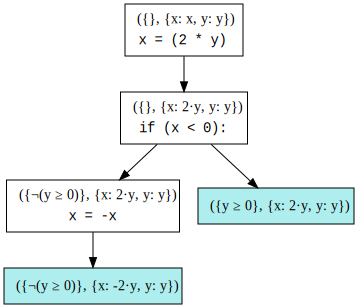

In [17]:
program = """
x = 2 * y
if x < 0:
    x = -x
"""

display_program(program)

x = Variable("x", INT_TYPE)
y = Variable("y", INT_TYPE)

env = SymbolicEnvironment(SymbolicStore({x: x.to_z3(), y: y.to_z3()}))
interpreter = SymbolicInterpreter()
tree = interpreter.execute(parse(program), env)

display_set(tree)

To try out something more complex, we revisit the linear search method from {ref}`minipy` (we slightly simplified the code, which originally should merely illustrate the extent of the minipy language).

In [18]:
program="""
def find(needle: int, haystack: tuple) -> int:
    i = 0
    while i < len(haystack):
        if haystack[i] == needle:
            break
        
        i = i + 1
    else:
        return -1
    
    return i

t = (1, 2, 3, 4, )
r = find(x, t)
"""

display_program(program)

```python
def find(needle: int, haystack: tuple) -> int:
    i = 0
    while i < len(haystack):
        if haystack[i] == needle:
            break
        
        i = i + 1
    else:
        return -1
    
    return i

t = (1, 2, 3, 4, )
r = find(x, t)
```

Instead of executing this program with a concrete "needle" value, we use a symbolic input `x`. Let's have a look at the result:

In [19]:
env = SymbolicEnvironment(SymbolicStore({x: x.to_z3()}))
interpreter = SymbolicInterpreter()

with ExpectError(print_traceback=False):
    tree = interpreter.execute(parse(program), env)
    display_set(tree)

NameError: name 'len' is not defined (expected)


Ooops... Apparently, the interpreter does not know the `len` function which is built into Python. This is not surprising: Even the concrete interpreter has to be told about existing built-in functions. For the symbolic interpreter, the situation is much more complex, since we cannot call a built-in Python function with symbolic arguments. There are two ways to approach this problem:

1. Implement the `len` function in minipy and add it to our program.
2. Summarize the `len` function with a symbolic expression.

Option (2) corresponds to the concept of *function summaries* or *contracts* {cite}`ahrendt.beckert.ea-16` {cite}`baldoni.coppa.ea-18`. Such a summary is basically a conjunction of pre- and postcondition pairs, such that if a precondition holds in the current state, the postcondition can be assumed after function execution. We choose this option to teach the symbolic interpreter about the `len` function, since it would be rather impractical to add full implementations of all used library functions to each analyzed program. Furthermore, summaries are a central concept of *compositional symbolic execution* {cite}`anand.godefroid.ea-08` (see also {ref}`techniques:compositional_se`). It allows to modularly execute one piece of code at a time to derive or prove its summary, while invoking other functions by their summaries instead of executing them repeatedly.

We extend the symbolic interpreter such that we can pass it a collection of predicates that will be considered in function calls whenever a function implementation is not available. Technically, we pass the interpreter a dictionary with predicate names as keys, and triples of argument sorts, target sort, and a Callable producing a symbolic value from the given arguments as values. For the `len` function:

In [20]:
predicates = {"len": ((z3.SeqSort(z3.IntSort()),), z3.IntSort(), z3.Length)}

In [21]:
class SymbolicInterpreter(SymbolicInterpreter):
    def __init__(self,
                 predicates: Optional[Dict[str, Tuple[Tuple[z3.SortRef, ...], z3.SortRef, Callable]]] = None):
        super().__init__()
        self.predicates: Dict[str, Tuple[Tuple[z3.SortRef], z3.SortRef, Callable]] = \
            {} if predicates is None else predicates

    def evaluate_fun_call(self, expr: FunctionCall, environment: SymbolicEnvironment) -> EvalExprResult:
        result: EvalExprResult = []

        f_name = expr.name
        if f_name not in environment.functions and f_name not in self.predicates:
            raise NameError(f"name '{f_name}' is not defined")

        args_result = [self.evaluate(arg, environment) for arg in expr.args]

        combinations: List[Tuple[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef], ...]] = \
            list(itertools.product(*args_result))

        combination: Tuple[Tuple[Union[SymbolicValueType, Exception], z3.BoolRef], ...]
        for combination in combinations:
            values: List[SymbolicValueType] = []
            path_constraint: z3.BoolRef = z3.BoolVal(True)
            sub_result: Tuple[Union[SymbolicValueType, Exception], z3.BoolRef]
            for sub_value, sub_constraint in combination:
                path_constraint = z3.simplify(z3.And(path_constraint, sub_constraint))
                if isinstance(sub_value, Exception):
                    result.append(wrap_exceptions((sub_value, path_constraint)))
                    break

                values.append(sub_value)

            if len(values) != len(combination):
                continue

            if f_name in environment.functions:
                params, ret_type, fun = environment.functions[f_name]
                if len(values) != len(params):
                    raise TypeError(f"{f_name}({', '.join(map(str, params))}) takes {len(params)} "
                                    f"argument(s) but {len(values)} were given")

                result.extend(fun(environment, *values))
            elif f_name in self.predicates:
                params_sorts, ret_sort, pred = self.predicates[f_name]
                if len(values) != len(params_sorts):
                    raise TypeError(f"{f_name}({', '.join(map(str, params_sorts))}) takes {len(params_sorts)} "
                                    f"argument(s) but {len(values)} were given")
                call_result: SymbolicValueType = pred(*values)
                assert call_result.sort() == ret_sort
                result.append((call_result, path_constraint))
            else:
                assert False

        return result

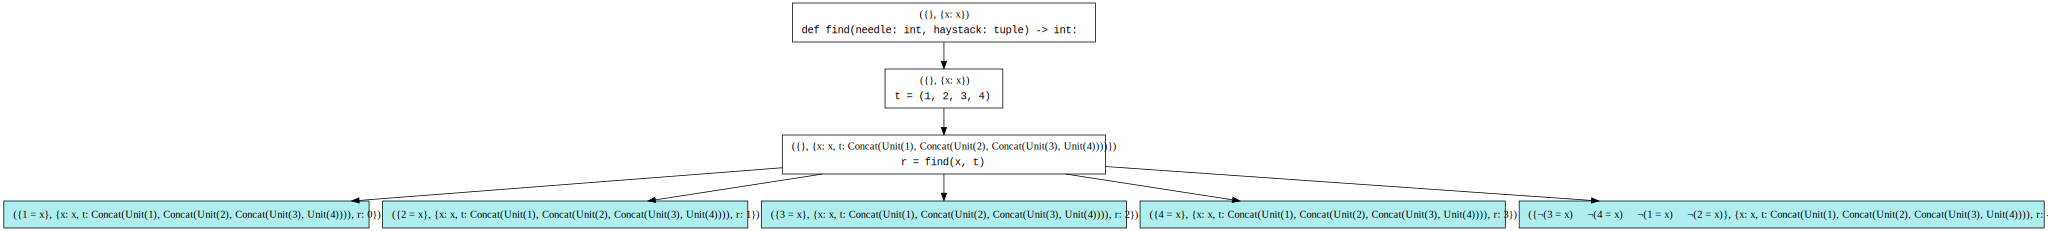

In [22]:
env = SymbolicEnvironment(SymbolicStore({x: x.to_z3()}))
interpreter = SymbolicInterpreter(predicates=predicates)

tree = interpreter.execute(parse(program), env)
display_set(tree)

Since the picture is a little oversized, here come the leaves of the tree:

In [23]:
def display_leaves(tree: SET):
    leaves = get_leaves(tree)
    for leaf, _ in leaves:
        display_html(leaf.environment.to_html())

In [24]:
display_leaves(tree)

The flat shape of the tree reveals one of the characteristics of our symbolic interpreter: Since function calls are evaluated as expressions, we do not see the SET corresponding to the execution of the function body. In {ref}`techniques:transparent_function_execution`, we describe how to transparently integrate SETs corresponding to called functions. Apart from that, the result is as expected: If `x` occurs in `t` (i.e., its value is between 1 and 4), the result value of variable `r` is `1 - x`, and -1 otherwise.

But what happens if we also leave the value of `t` symbolic? In that case, the interpreter would continue unrolling the loop until the stack overflows (we do not demonstrate this here since a timeout is hard to implement in Python). In presence of a symbolic tuple `t`, we obtain an *unbounded loop*. A straightforward to deal with such unbounded loops solution is to only unroll loops until a maximum depth. We extend the symbolic interpreter with a depth bound for loops.

In [25]:
class SymbolicInterpreter(SymbolicInterpreter):
    def __init__(self,
                 loop_unrolling_threshold: Optional[int] = None,
                 predicates: Optional[Dict[str, Tuple[Tuple[z3.SortRef, ...], z3.SortRef, Callable]]] = None):
        super().__init__(predicates)
        self.loop_unrolling_threshold = loop_unrolling_threshold

    def execute(self, stmt: ASTNode, environment: SymbolicEnvironment,
                loop_unrolling_threshold: Optional[int] = None) -> SET:
        self.logger.debug("Executing statement %s", stmt.code)

        loop_unrolling_threshold = (
            loop_unrolling_threshold if loop_unrolling_threshold is not None
            else self.loop_unrolling_threshold)

        t = type(stmt)
        if isinstance(stmt, WhileStmt):
            return self.execute_while_stmt(stmt, environment, loop_unrolling_threshold)

        if t in self.stmt_interpretations:
            return self.stmt_interpretations[t](stmt, environment)

        if isinstance(stmt, Expression):
            # Expression Statements
            return SETNode(environment, stmt.code), [(SETNode(environment.add_constraint(constraint), None), [])
                                                     for _, constraint in self.evaluate(stmt, environment)]

        assert False

    def execute_while_stmt(self, stmt: WhileStmt, environment: SymbolicEnvironment,
                           loop_unrolling_threshold: Optional[int] = None) -> SET:
        loop_unrolling_threshold = (-1 if loop_unrolling_threshold is None
                                    else loop_unrolling_threshold)

        eval_guard_res = self.evaluate(stmt.guard, environment)
        result = (SETNode(environment, stmt.code), [])

        for value, constraint in eval_guard_res:
            if isinstance(value, Exception):
                exc_node = SETNode(environment.add_constraint(constraint).set_abrupt_completion(value), '')
                if not exc_node.environment.unsatisfiable():
                    result[1].append((exc_node, []))
                continue

            then_constraint: z3.BoolRef = z3.simplify(value)
            then_env = environment.add_constraint(constraint).add_constraint(then_constraint)

            if not then_env.unsatisfiable() and loop_unrolling_threshold != 0:
                subtree = self.execute(stmt.body, then_env)
                result[1].append(subtree)
                for leaf in get_leaves(subtree):
                    node, _ = leaf
                    env = node.environment
                    exc = env.abrupt_completion
                    if exc is not None:
                        if isinstance(exc, Continue):
                            env = env.set_abrupt_completion(None)
                        elif isinstance(exc, Break):
                            env = env.set_abrupt_completion(None)
                            result = replace_in_tree(
                                result, leaf, (SETNode(env, ''), []))
                            continue
                        else:
                            continue

                    while_tree = self.execute(stmt, env, loop_unrolling_threshold - 1)
                    result = replace_in_tree(result, leaf, while_tree)
                    continue

            else_constraint: z3.BoolRef = z3.simplify(z3.Not(value))
            else_env = environment.add_constraint(constraint).add_constraint(else_constraint)

            if not else_env.unsatisfiable():
                if stmt.else_block is not None:
                    subtree = self.execute(stmt.else_block, else_env)
                    result[1].append((SETNode(else_env, 'else:'), [subtree]))
                else:
                    result[1].append((SETNode(else_env, ''), []))

        return result

This time, we directly execute the body of the `find` function to obtain an SET for the actual loop:

In [30]:
program="""i = 0
while i < len(haystack):
    if haystack[i] == needle:
        break
    i = i + 1
else:
    return -1

return i
"""

display_program(program)

```python
i = 0
while i < len(haystack):
    if haystack[i] == needle:
        break
    i = i + 1
else:
    return -1

return i
```

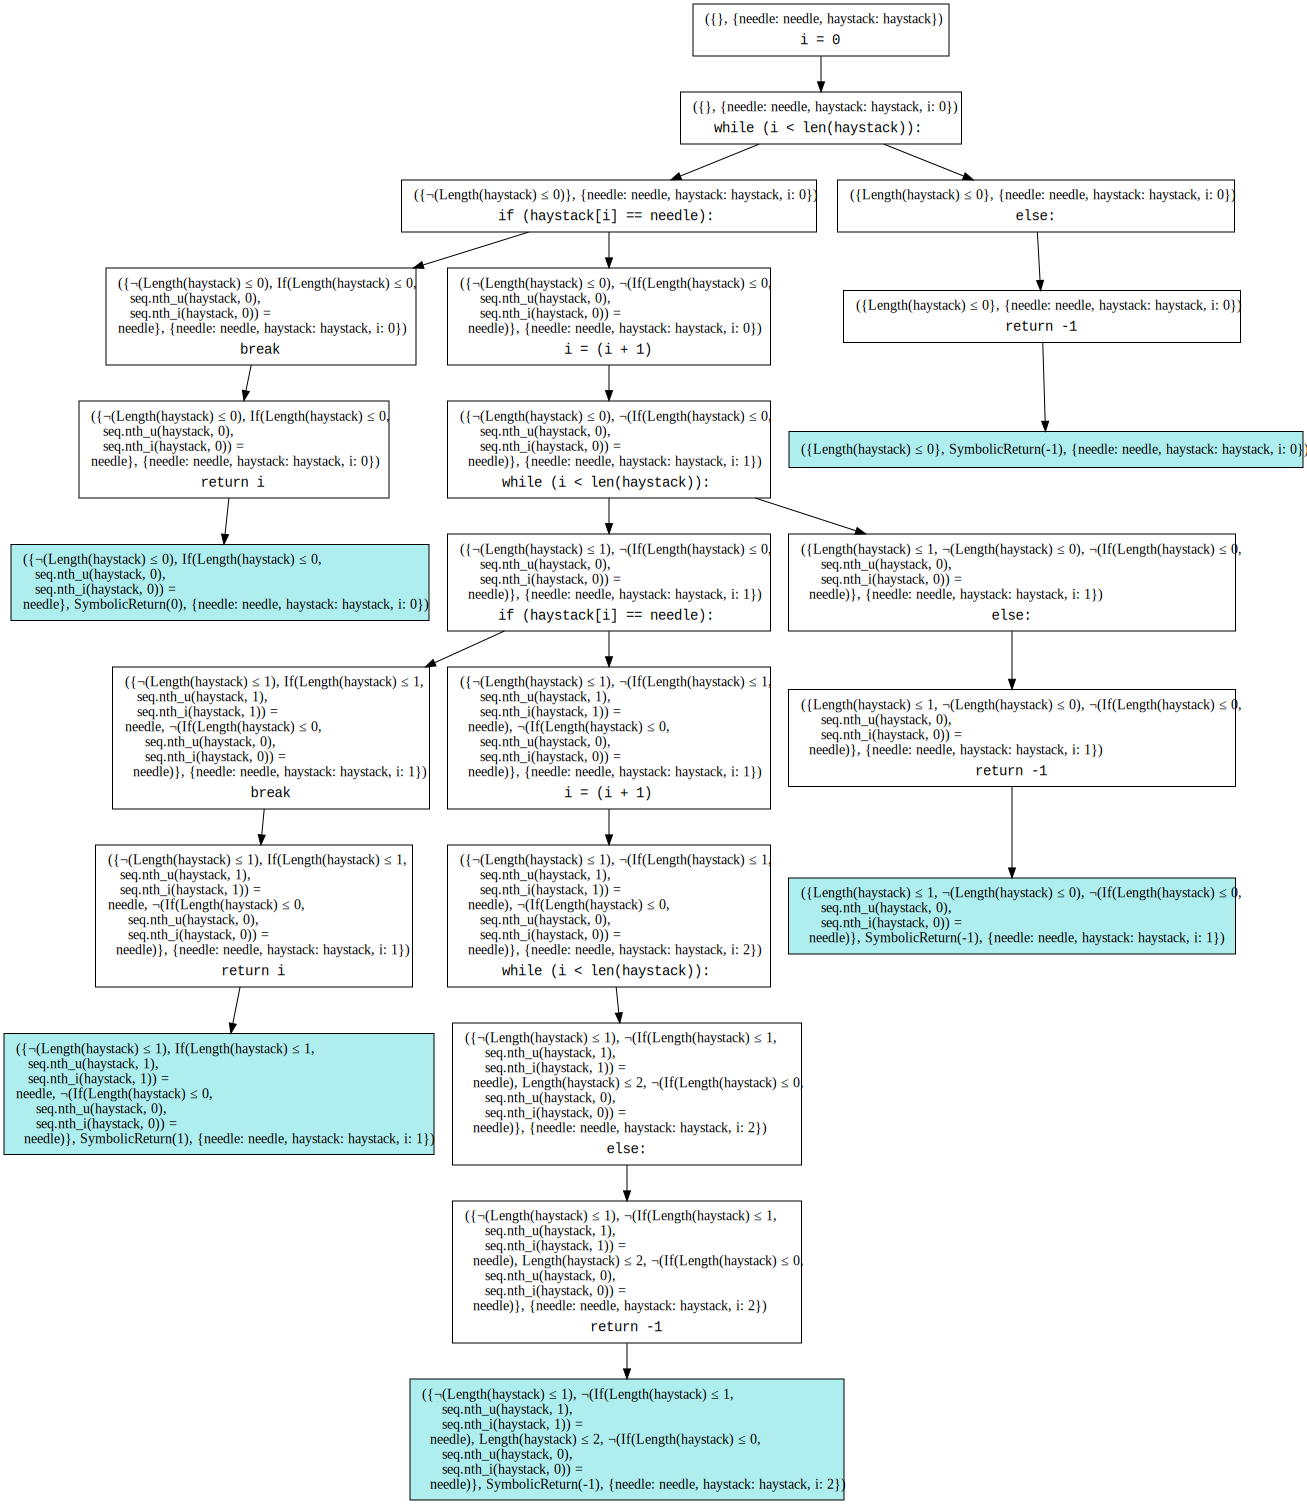

In [31]:
needle = Variable("needle", INT_TYPE)
haystack = Variable("haystack", TUPLE_TYPE)

env = SymbolicEnvironment(SymbolicStore({needle: needle.to_z3(), haystack: haystack.to_z3()}))
interpreter = SymbolicInterpreter(predicates=predicates, loop_unrolling_threshold=2)
tree = interpreter.execute(parse(program), env)

display_set(tree)

In [32]:
display_leaves(tree)

For each tuple index within our set bound of 2, we obtain two leaves: One where the searched-for element has been found (the abrupt completion flag is set to `SymbolicReturn(index)`, where `index` is the first position where `needle` has been found), and one where it has not been found (`SymbolicReturn(-1)`). Additionally, we have one leaf for the case where the tuple is empty (Length(haystack) ≤ 0).

In {ref}`techniques:loops_static_se`, we introduce a technique based on *loop invariants* (summaries for loops), which allows to symbolically execute loops (in an online, static symbolic interpreter) without depth bounds.

But what does it actually mean to stop SE after a given bound has exceeded? What is the effect of choosing coarse summaries for functions or loops? And how can we check whether the implementation of the symbolic interpreter discussed in this section is correct? These questions are related to the *semantics* of symbolic transition systems, which we discuss next.

## References

```{bibliography}
:filter: docname in docnames
```

[^floor-division]: See https://docs.python.org/3/reference/expressions.html#index-67